In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.Observables import Observable
from src.Shaper import Shaper
from src.Manifolds import Coordinates2D, Simplex

# Utils
from utils.data_utils import load_cmsopendata, load_dataset, calculate_masses, normalize_events, add_pileup
from utils.plot_utils import plot_event
from ot.lp import emd2

# Jets
from pyjet import cluster




/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Data

(10000, 200, 3)
(10000, 200, 3)
652.7005


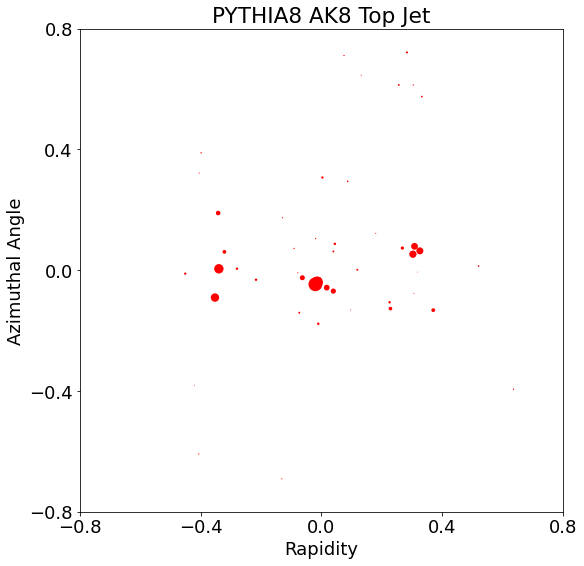

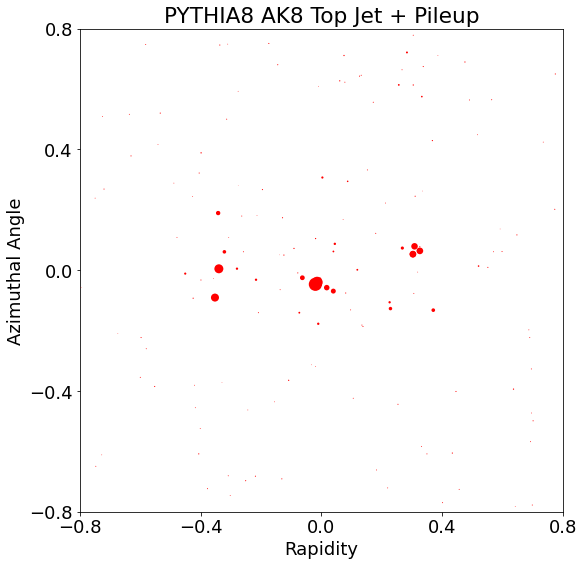

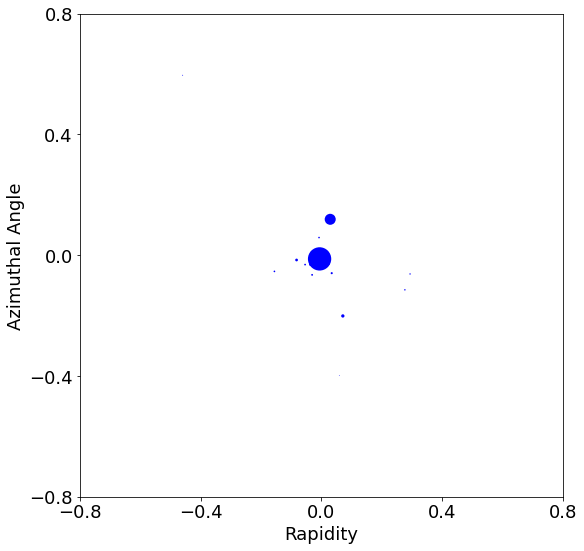

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
# Parameters
R = 0.8
beta = 1
N = 100

mass_lower = 0
mass_upper = np.inf
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"



# cms, cms_weights = load_cmsopendata("data", "cms", pt_lower, pt_upper, eta, quality, pad, n = N)
# sim, sim_weights, sim_factors = load_cmsopendata("data", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)
# print(cms_weights.shape)
# events = (cms, sim)


# Load events
signal = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
background = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta, normalize = False)
signal_mass = calculate_masses(signal)
background_mass = calculate_masses(background)


# Add pileup
signal_pu = normalize_events(add_pileup(signal, 100, 50, 250, 25, R))
background_pu = normalize_events(add_pileup(background, 100, 50, 250, 25, R))
signal_pu_mass = calculate_masses(signal_pu)
background_pu_mass = calculate_masses(background_pu)



events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]




# Example plots
example_signal = signal[0]
example_signal_pu = signal_pu[0]
print(example_signal[1].sum())
plot_event(example_signal[0], example_signal[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet", filename= "Plots/top.pdf")
plot_event(example_signal_pu[0], example_signal_pu[1], R, color = "red", title = "PYTHIA8 AK8 Top Jet + Pileup", filename = "Plots/top_pileup.pdf")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")





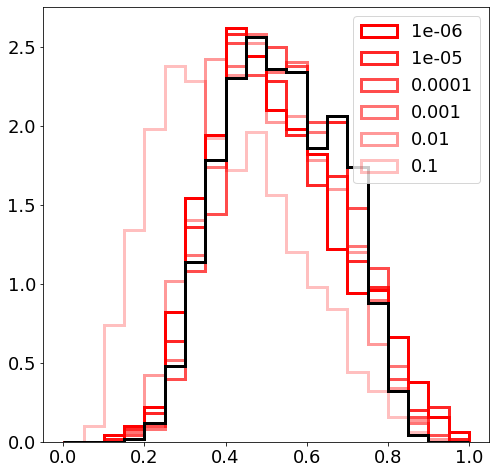

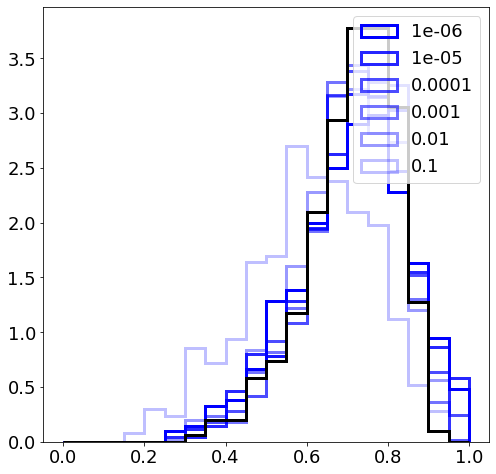

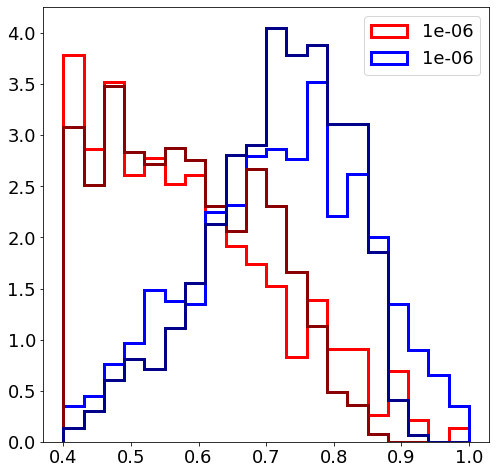

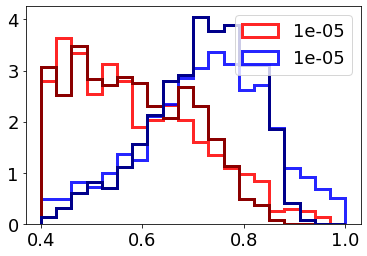

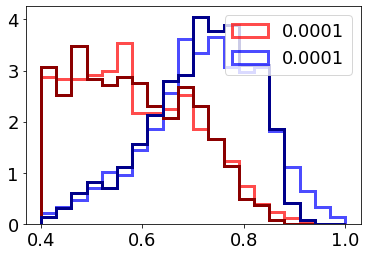

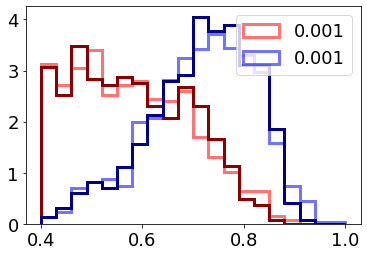

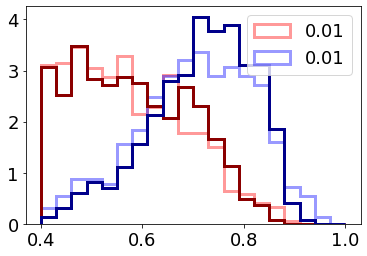

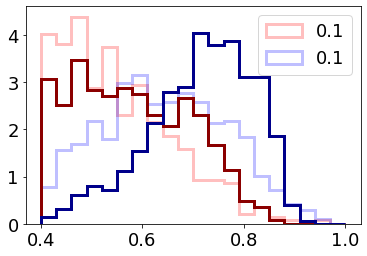

(2000,)
(2000,)
(2000,)
(2000,)
(2000,)
(2000,)


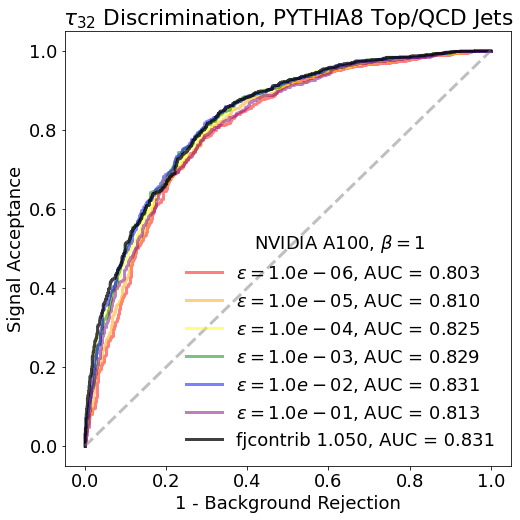

(500,)
(500,)
(500,)
(500,)
(500,)
(500,)


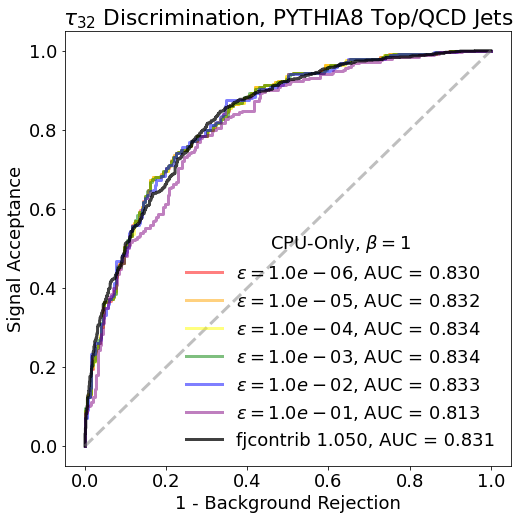

In [3]:
Ns = [1, 2, 3]
epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
offsets = [.004, 0.002, 0, 0, 0, 0]
offsets = [.000, 0.000, 0, 0, 0, 0]
epsilon_exponents = [-6, -5, -4, -3, -2, -1]


# ROC Curves for tau_32
from sklearn.metrics import roc_curve, auc



def tau32_hist(true_nsubjettiness = True, dataset = "signal", color = "red"):

    signal_emds_sinkhorn = np.load("data/%s_90_nsubjettiness_emds_sinkhorn.npy" % dataset)
    if true_nsubjettiness:
        signal_emds_pot = np.loadtxt("NSubjettiness/%s_tau32.dat" % dataset)
    else:
        signal_emds_pot = np.load("data/%s_90_nsubjettiness_emds_pot.npy" % dataset)

    fig = plt.figure(figsize=(8, 8))



    for (e, eps) in enumerate(epsilons):

        signal_tau_sinkhorn = signal_emds_sinkhorn[e, 2, :] / signal_emds_sinkhorn[e, 1, :]
        plt.hist(signal_tau_sinkhorn, color = color, bins = 20, range = [0,1], alpha = 1 - e*0.15, label=eps, histtype="step", lw = 3, density = True)

    plt.hist(signal_emds_pot, color = "black", bins = 20, range = [0,1], histtype="step", lw = 3, density = True)
    plt.legend()

    plt.show()
    plt.close()    


def signal_background_hist(true_nsubjettiness = True, ):

    signal_emds_sinkhorn = np.load("data/%s_90_nsubjettiness_emds_sinkhorn.npy" % "signal")
    if true_nsubjettiness:
        signal_emds_pot = np.loadtxt("NSubjettiness/%s_tau32.dat" % "signal")
    else:
        signal_emds_pot = np.load("data/%s_90_nsubjettiness_emds_pot.npy" % "signal")


    background_emds_sinkhorn = np.load("data/%s_90_nsubjettiness_emds_sinkhorn.npy" % "background")
    if true_nsubjettiness:
        background_emds_pot = np.loadtxt("NSubjettiness/%s_tau32.dat" % "background")
    else:
        background_emds_pot = np.load("data/%s_90_nsubjettiness_emds_pot.npy" % "background")

    fig = plt.figure(figsize=(8, 8))



    for (e, eps) in enumerate(epsilons):

        signal_tau_sinkhorn = signal_emds_sinkhorn[e, 2, :] / signal_emds_sinkhorn[e, 1, :]
        background_tau_sinkhorn = background_emds_sinkhorn[e, 2, :] / background_emds_sinkhorn[e, 1, :]
        plt.hist(signal_tau_sinkhorn, color = "red", bins = 20, range = [0.4,1], alpha = 1 - e*0.15, label=eps, histtype="step", lw = 3, density = True)
        plt.hist(background_tau_sinkhorn, color = "blue", bins = 20, range = [0.4,1], alpha = 1 - e*0.15, label=eps, histtype="step", lw = 3, density = True)


        plt.hist(signal_emds_pot, color = "darkred", bins = 20, range = [0.4,1], histtype="step", lw = 3, density = True)
        plt.hist(background_emds_pot, color = "darkblue", bins = 20, range = [0.4,1], histtype="step", lw = 3, density = True)
        plt.legend()

        plt.show()
        plt.close()  


def ROC(true_nsubjettiness = True, gpu = True):


    Ns = [1, 2, 3]
    epsilons = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
    offsets = [.004, 0.002, 0, 0, 0, 0] if not gpu else [.000, 0.000, 0, 0, 0, 0]
    # offsets = [.000, 0.000, 0, 0, 0, 0]

    gpu_data_string = "90"
    cpu_data_string = "cpu"
    data_string = gpu_data_string if gpu else cpu_data_string



    signal_emds_sinkhorn = np.load("data/signal_%s_nsubjettiness_emds_sinkhorn.npy" % data_string)
    if true_nsubjettiness:
        signal_emds_pot = np.loadtxt("NSubjettiness/signal_tau32.dat")
    else:
        signal_emds_pot = np.load("data/signal_%s_nsubjettiness_emds_pot.npy" % data_string)


    background_emds_sinkhorn = np.load("data/background_%s_nsubjettiness_emds_sinkhorn.npy" % data_string)
    if true_nsubjettiness:
        background_emds_pot = np.loadtxt("NSubjettiness/background_tau32.dat")
    else:
        background_emds_pot = np.load("data/background_%s_nsubjettiness_emds_pot.npy" % data_string)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]
    colors = colors[::]

    for (e, eps) in enumerate(epsilons[::]):

        signal_tau_sinkhorn = signal_emds_sinkhorn[e, 2, :] / signal_emds_sinkhorn[e, 1, :]
        background_tau_sinkhorn = background_emds_sinkhorn[e, 2, :] / background_emds_sinkhorn[e, 1, :]

        labels = np.concatenate((np.zeros((signal_tau_sinkhorn.shape[0],)), np.ones((background_tau_sinkhorn.shape[0],))))
        print(labels.shape)
        y_= np.concatenate((signal_tau_sinkhorn, background_tau_sinkhorn))

        fpr, tpr, _ = roc_curve(labels, y_)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr  + 0* 0.0025*e, color = colors[e], alpha = 0.5, label = r"$\epsilon = 10^{%d}$, AUC = %.3f" % (epsilon_exponents[e], roc_auc - offsets[e]), lw = 3)


    if true_nsubjettiness:
        signal_tau_pot = signal_emds_pot
        background_tau_pot = background_emds_pot
    else:
        signal_tau_pot = signal_emds_pot[2, :] / signal_emds_pot[1, :]
        background_tau_pot = background_emds_pot[2, :] / background_emds_pot[1, :]
    labels = np.concatenate((np.zeros((signal_tau_pot.shape[0],)), np.ones((background_tau_pot.shape[0],))))
    y_= np.concatenate((signal_tau_pot, background_tau_pot))
    fpr, tpr, _ = roc_curve(labels, y_)
    roc_auc = auc(fpr, tpr)

    if true_nsubjettiness:
        plt.plot(fpr, tpr, color = "black", alpha = 0.75, label = r"fjcontrib 1.050, AUC = %.3f" % roc_auc, lw = 3)
    else:
        plt.plot(fpr, tpr, color = "black", alpha = 0.75, label = r"Exclusive $k_T$", lw = 3)
        
    plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), color = "grey", alpha = 0.5, ls = "--", lw = 3)
    plt.title("$\\tau_{32}$ Discrimination, PYTHIA8 Top/QCD Jets")
    plt.ylabel("Signal Acceptance")
    plt.xlabel("1 - Background Rejection")
    plt.legend(frameon = False, title = r"NVIDIA A100, $\beta = 1$" if gpu else r"CPU-Only, $\beta = 1$")
    plt.savefig("roc_benchmarks_gpu.pdf" if gpu else "roc_benchmarks_cpu.pdf")
    plt.show()
    plt.close()

    # plt.hist(signal_tau_pot)
    # plt.hist(signal_tau_pot)


    

tau32_hist(dataset="signal", color = "red")
tau32_hist(dataset="background", color = "blue")

signal_background_hist()

ROC(gpu = True)  
ROC(gpu = False)

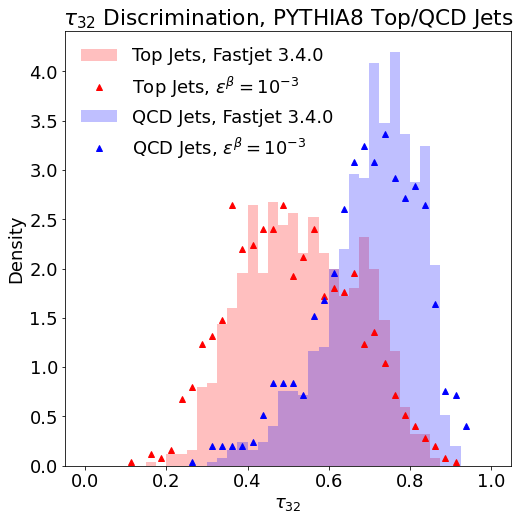

In [16]:
def isotropy_hist(dataset):



    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plt.rcParams['font.size'] = '18'
    lims = [0, 1.0]

    redshades = ["lightcoral", "red", "darkred"]
    blueshades = ["royalblue", "blue", "darkblue"]
    markers = ["o", "^", "x"]
    beta_colors = [redshades, blueshades]
    beta_ls = ["-", "--"]
    labels = ["Top Jets", "QCD Jets"]
    size_color_prefixes = []
    colors = ["red", "orange", "yellow", "green", "blue", "purple"]




    for (d,dataset) in enumerate(["signal", "background"]):

        emds_sinkhorn = np.load("data/%s_90_nsubjettiness_emds_sinkhorn.npy" % dataset)
        emds_pot = np.loadtxt("NSubjettiness/%s_tau32.dat" % dataset)

       
        signal_tau_sinkhorn = emds_sinkhorn[-2, 2, :] / emds_sinkhorn[-2, 1, :]


        ax.hist(emds_pot, density = True, color = beta_colors[d][1], alpha = 0.25, range = [0, 1], bins = 40,label = r"%s, fjcontrib 1.050" % labels[d])
        

        counts, bin_edges = np.histogram(signal_tau_sinkhorn, bins=40, range=[0,1], density = True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        ax.plot(bin_centers[counts > 0], counts[counts > 0], marker = markers[1], color = beta_colors[d][1], label=r"%s, $\epsilon^{\beta} = 10^{-3}$" % (labels[d]) , ls = "none")

                
                # ax.hist(emds_sinkhorn[3,-2], density = True, color = beta_colors[b][nxn], alpha = 0.75, range = [0, 0.75], bins = 50)
                # ax.errorbar(epsilons*(1 + 0.2*(nxn - 1)), mean, color = beta_colors[b][nxn], alpha = 0.75, marker = markers[nxn], ls = "none", label = r"$%d\times%d, \beta = %d$" % (NxN, NxN, beta), capsize = 3, capthick = 1)
                # ax.plot(epsilons*(1 + 0.2*(nxn - 1)), mean, color = beta_colors[b][nxn], alpha = 0.75, marker = markers[nxn], ls = beta_ls[b], label = r"$%d\times%d, \beta = %d$" % (NxN, NxN, beta),)
                # ax.scatter(epsilons*(1 + 0.2*(nxn - 1)), mean, color = beta_colors[b][nxn], alpha = 0.75, marker = markers[nxn], s = 100)



    # plt.xscale("log")
    # plt.yscale("log")
    # plt.ylim(ylim)
    # plt.xlim(xlim)
    plt.xlabel("$\\tau_{32}$")
    plt.ylabel("Density")
    plt.title("$\\tau_{32}$ Discrimination, PYTHIA8 Top/QCD Jets")
    plt.legend(loc = "upper left", ncol = 1, frameon = False)
    # plt.ylabel(r"$\mathcal{I}_{%d}^{\epislon} / \mathcal{I}_{%d}$" % (n**2, n**2) )
    # plt.show()
    plt.savefig("Plots/tau32_distributions.pdf")
    plt.show()

isotropy_hist("")
